#### Multi-Agent System

- https://langchain-ai.github.io/langgraph/concepts/multi_agent/#multi-agent-architectures
- https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/
- https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration/

##### Importing required libraries

In [1]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langgraph.graph import StateGraph,START,END
from typing import Literal
from langchain_core.messages import BaseMessage,HumanMessage
from langchain_groq import ChatGroq
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph,START,END,MessagesState
from langgraph.types import Command

In [2]:
tool_tavily_search = TavilySearchResults(max_results=5)

repl = PythonREPL()


@tool
def tool_python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [3]:
llm = ChatGroq(model="deepseek-r1-distill-llama-70b",temperature=0.3)

In [4]:
# Define the agent nodes
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [5]:
# Define the agents
research_agent = create_react_agent(llm,tools=[tool_tavily_search],prompt=make_system_prompt(suffix="You can only do research. You are working with a chart generator colleague."))
chart_agent = create_react_agent(llm,tools=[tool_python_repl],prompt=make_system_prompt(suffix="You can only generate charts. You are working with a researcher colleague."))


In [6]:
def get_next_node(last_message:BaseMessage,goto:str):
    if 'FINAL ANSWER' in last_message.content:
        return END
    return goto

In [7]:
# Define the nodes
def research_node(state:MessagesState) -> Command[Literal["chart_generator",END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1],"chart_generator")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content,name="researcher")
    return Command(update={"messages":state["messages"]},goto=goto)

def chart_node(state:MessagesState) -> Command[Literal["researcher",END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1],"researcher")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content,name="researcher")
    return Command(update={"messages":state["messages"]},goto=goto)

In [8]:
# Create the graph
workflow = StateGraph(MessagesState)
workflow.add_node("researcher",research_node)
workflow.add_node("chart_generator",chart_node)

workflow.add_edge(START,"researcher")
graph = workflow.compile()

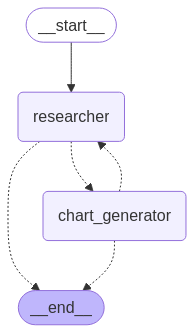

In [9]:
graph

{'researcher': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='8ad62b17-b020-422e-bd78-fd701a4d86a3')]}}
-------


Python REPL can execute arbitrary code. Use with caution.


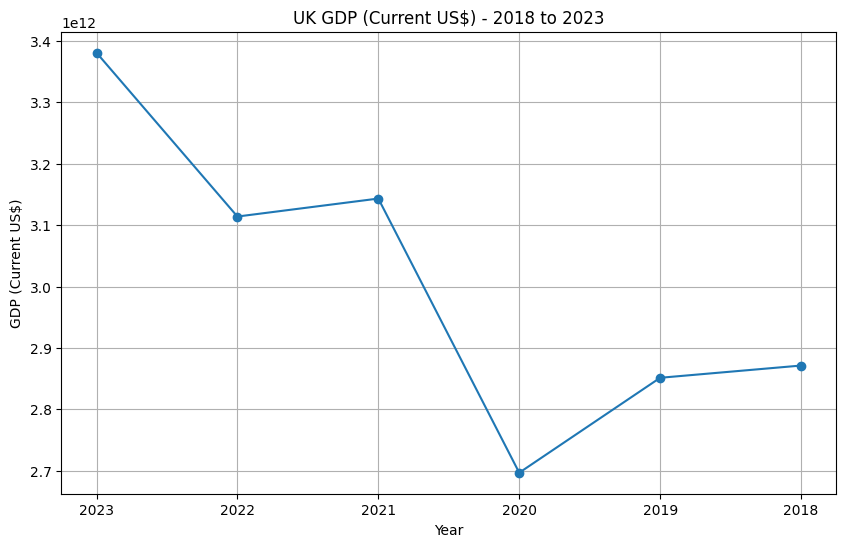

{'chart_generator': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='8ad62b17-b020-422e-bd78-fd701a4d86a3')]}}
-------


In [10]:
events = graph.stream(
    {
        "messages" : [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ]
    },
    {"recursion_limit": 150}
)
for s in events:
    print(s)
    print("-------")